In [9]:
import pandas as pd
import numpy as np
import pickle
import gc
from pathlib import Path
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils, localizer, shap_analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v3/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

# challenge_data_dir = Path('submission/dataset/')
# data_dir = challenge_data_dir / "test"
# labels_dir = challenge_data_dir / 'test_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir, dtype=np.float32)

#some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:900]}

In [24]:
ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes,
                                      non_transform_features=['Eccentricity',
                                                                            'Semimajor Axis (m)',
                                                                            'Inclination (deg)',
                                                                            'RAAN (deg)',
                                                                            #'Argument of Periapsis (deg)',
                                                                            #'True Anomaly (deg)',
                                                                            #'Longitude (deg)',
                                                                            'Latitude (deg)'],
                                                    diff_transform_features=[#'Eccentricity',
                                                                            #'Semimajor Axis (m)',
                                                                            'Inclination (deg)',
                                                                            #'RAAN (deg)',
                                                                            #'Argument of Periapsis (deg)',
                                                                            'True Anomaly (deg)',
                                                                            'Longitude (deg)',
                                                                            #'Latitude (deg)'
                                                                            ],
                                                    sin_transform_features=[#'Eccentricity',
                                                                            #'Semimajor Axis (m)',
                                                                            #'Inclination (deg)',
                                                                            #'RAAN (deg)',
                                                                            'Argument of Periapsis (deg)',
                                                                            #'True Anomaly (deg)',
                                                                            #'Longitude (deg)',
                                                                            #'Latitude (deg)'
                                                                            ],
                                                    sin_cos_transform_features=[],
                                                    overview_features_mean=[#'Longitude (sin)',
                                                                            #'RAAN (deg)'
                                                                            ],
                                                    overview_features_std=['Inclination (deg)'
                                                                            ],
                                    add_daytime_feature=False,
                                    add_yeartime_feature=False,
                                    add_linear_timeindex=True,
                                    linear_timeindex_as_overview=True,
                                    input_history_steps=320,
                                    input_future_steps=256,
                                    input_stride=4,
                                      with_labels=True,
                                      nonbinary_padding=[110.0],
                                      train_val_split=0.8,
                                      padding='zero',
                                      per_object_scaling=False,
                                      scale=True,
                                      custom_scaler=None,
                                      unify_value_ranges=True,
                                      input_dtype=np.float32,
                                      sort_inputs=True,
                                      seed=11)

=========================Creating Generator=======================
Seed: 11
nTrain: 1520 nVal: 380 (0.80)
Padding: zero
Horizons: 320-256 @ stride 4
Scaling: True  
Limiting True Anomaly to [0.0, 360.0] and Longitude to [-180.0, 180.0]
Sin-Transforming features: ['Argument of Periapsis (deg)']
Sin-Cos-Transforming features: []
Diff Transforming features: ['Inclination (deg)', 'True Anomaly (deg)', 'Longitude (deg)']
Adding linear timeindex.
Padding node locations in non-binary fashion ([110.0])


In [5]:
train_ds, val_ds = ds_gen.get_datasets(2048,
                                          label_features=['EW_Node_Location_nb', 'NS_Node_Location_nb'],
                                          shuffle=True,
                                          only_ew_sk=False,
                                          only_nodes=False,
                                          stride=1,
                                          keep_label_stride=40,
                                          stride_offset=200,
                                          verbose=1)

print(train_ds.element_spec) # 673786

  0%|          | 0/1520 [00:00<?, ?it/s]

100%|██████████| 1520/1520 [00:13<00:00, 111.99it/s]
2024-03-31 16:50:44.304550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 16:50:44.336536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 16:50:44.336642: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 16:50:44.338912: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 16:5

Train-DS Cardinality: tf.Tensor(8340, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(2093, shape=(), dtype=int64)
({'local_in': TensorSpec(shape=(None, 288, 15), dtype=tf.float32, name=None)}, {'EW_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


In [6]:
model = tf.keras.models.load_model("submission/models/model_hh1tr1qp.hdf5", compile=True)

In [10]:
shap_vals = shap_analysis.get_shap_values_from_ds(model, train_ds, val_ds, n_t=400, n_v=100)

2024-03-31 16:53:21.078787: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


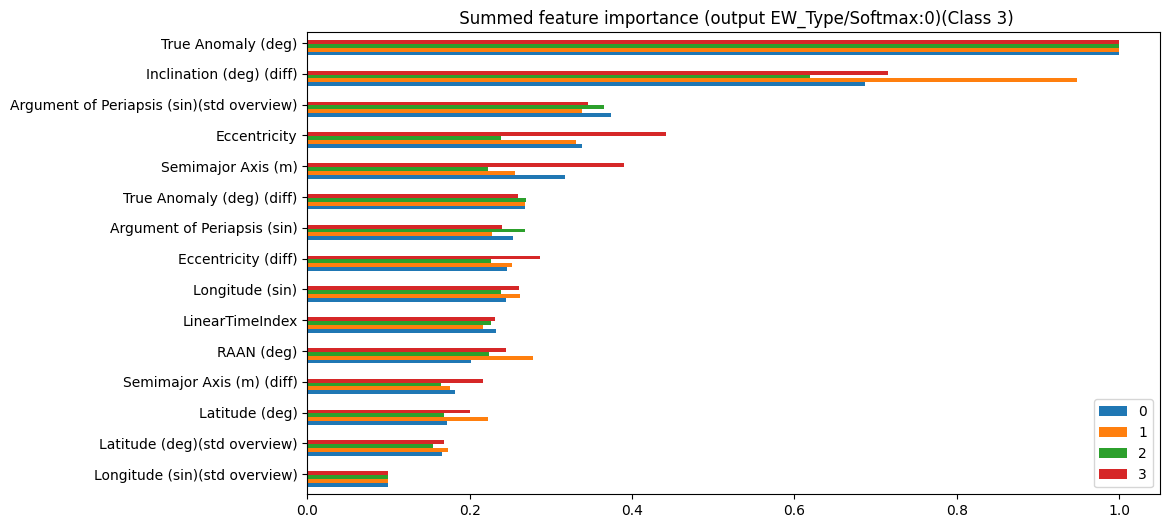

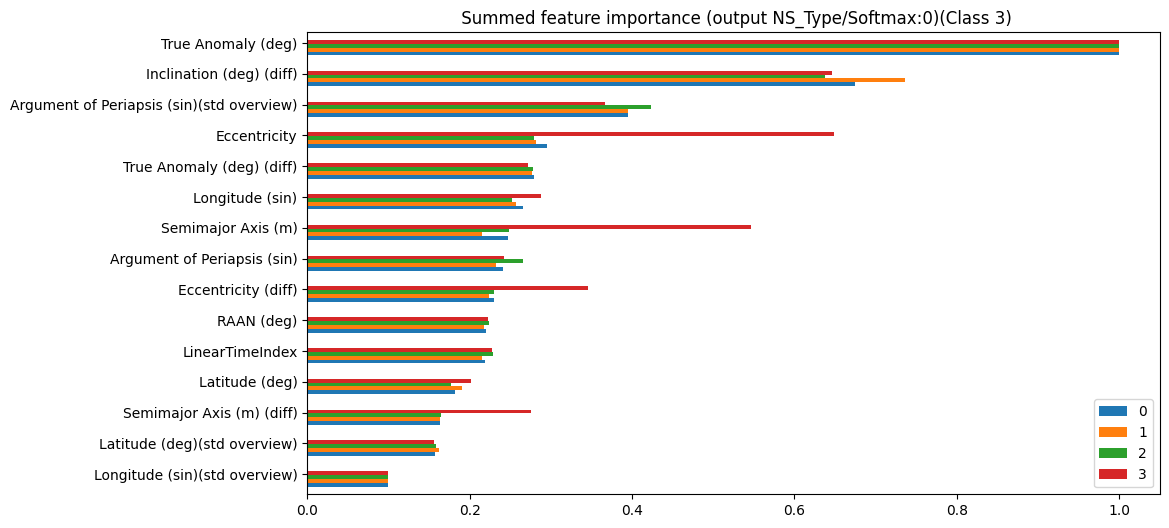

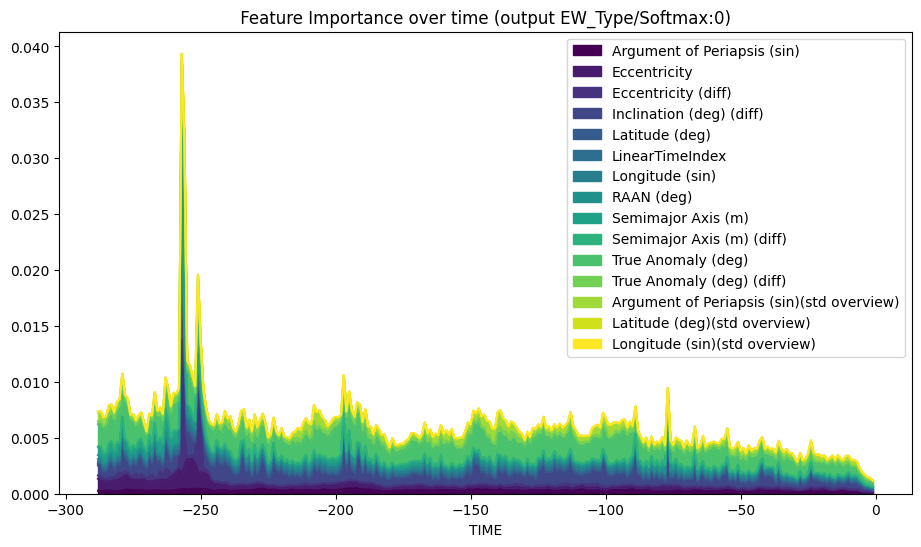

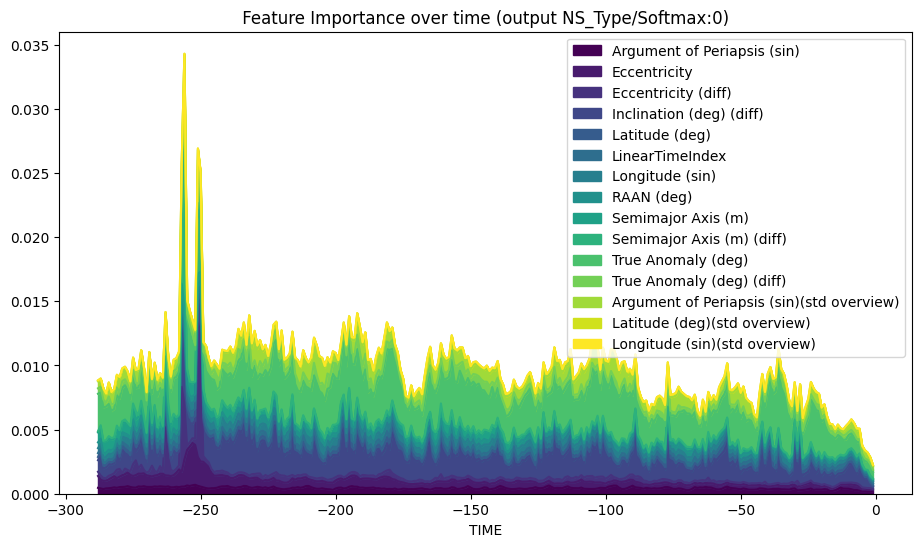

In [23]:
ft_cols = ds_gen._input_features + [ft+'(mean overview)' for ft in ds_gen._overview_features_mean] + [ft+'(std overview)' for ft in ds_gen._overview_features_std]
shap_analysis.plot_ft_importance_bars(shap_vals, ft_cols)
shap_analysis.plot_ft_importance_over_time(shap_vals, ft_cols)